In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cpu
Torchvision version: 0.24.0+cpu
CUDA is available: False


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../models/sam_hq_vit_l.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)


input_path = "../data/stitched_images/stitched_111.jpg"

image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
image = cv2.equalizeHist(image)
image = cv2.medianBlur(image, 39)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
predictor.set_image(image)

input_box = np.array([950, 1000, 1450, 5000])

masks, _, _ = predictor.predict(
    point_coords=np.array([[1200, 1000]]),
    point_labels=np.array([1]),
    box=input_box[None, :],
    multimask_output=False,
)

mask = masks[0]

/home/vscode/.local/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/vscode/.local/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/app/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/app/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry wit

<All keys matched successfully>


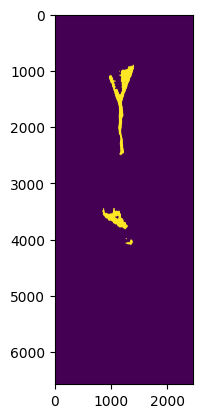

In [5]:
plt.figure()
plt.imshow(mask)
plt.show()

In [6]:
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
largest_mask = np.zeros_like(mask, dtype=np.uint8)
cv2.drawContours(largest_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(6574, 2464), dtype=uint8)

In [25]:
import polars as pl

path = '../data/final_est/agg_results.csv'

df = pl.read_csv(path)

df

image_name,num,seg_confidence,crack_length_mm,actual_length,actual_crack_length_mm,,_duplicated_0,_duplicated_1,_duplicated_2,_duplicated_3
str,i64,f64,f64,f64,f64,str,str,str,i64,f64
"""stitched_10.jpg""",10,0.892305,4.37,5.13,5.13,null,null,null,1,7.054
"""stitched_100.jpg""",100,0.827452,2.82,2.67,2.67,null,null,null,2,8.87
"""stitched_101.jpg""",101,0.628906,3.24,3.434,3.434,null,null,null,3,3.039
"""stitched_102.jpg""",102,0.880921,2.29,2.649,2.649,null,null,null,4,2.587
"""stitched_103.jpg""",103,0.879446,2.93,3.591,3.591,null,null,null,5,3.296
…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,null,null,null,null,128,4.072
null,null,null,null,null,null,null,null,null,129,3.849
null,null,null,null,null,null,null,null,null,130,2.79


In [26]:
df = df.filter(
    (pl.col('actual_crack_length_mm').is_not_null()) &
    (pl.col('seg_confidence') > 0.6)
)

In [27]:
df = df.with_columns(
    (np.abs(1 - (pl.col('crack_length_mm') / pl.col('actual_crack_length_mm')))).alias('percentage_error')
)

In [36]:
df.filter(pl.col('percentage_error') > 0.35).sort(pl.col('percentage_error'), descending=True)

image_name,num,seg_confidence,crack_length_mm,actual_length,actual_crack_length_mm,,_duplicated_0,_duplicated_1,_duplicated_2,_duplicated_3,percentage_error
str,i64,f64,f64,f64,f64,str,str,str,i64,f64,f64
"""stitched_105.jpg""",105,0.631071,12.57,3.818,3.818,null,null,null,7,4.1,2.2923
"""stitched_96.jpg""",96,0.734529,3.58,1.227,1.227,null,null,null,112,3.565,1.917685
"""stitched_47.jpg""",47,0.655971,0.0,2.662,2.662,null,null,null,63,4.553,1.0
"""stitched_7.jpg""",7,0.890203,7.1,4.1,4.1,null,null,null,86,5.275,0.731707
"""stitched_5.jpg""",5,0.911875,1.65,3.296,3.296,null,null,null,66,4.703,0.499393
"""stitched_45.jpg""",45,0.809978,3.22,6.19,6.19,null,null,null,61,2.749,0.479806
"""stitched_53.jpg""",53,0.676667,3.29,5.37,5.37,null,null,null,70,3.467,0.387337
"""stitched_88.jpg""",88,0.893695,2.71,4.22,4.22,null,null,null,104,3.813,0.35782
"""stitched_63.jpg""",63,0.837489,2.94,4.553,4.553,null,null,null,79,3.339,0.354272


In [8]:
import matplotlib.pyplot as plt

# plt.figure()
# plt.scatter(df['actual_crack_length_mm'], df['crack_length_mm'])
# plt.xlim(plt.xlim())
# plt.ylim(plt.ylim())
# plt.plot([0, 500], [0, 500], 'r--')
# plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Assuming df is your DataFrame with columns 'actual_crack_length_mm' and 'crack_length_mm'

df = df.filter(
    (pl.col('actual_crack_length_mm').is_not_null()) &
    (pl.col('seg_confidence') > 0.7)
)
x = df['actual_crack_length_mm'].to_numpy()
y = df['crack_length_mm'].to_numpy()
conf = df['seg_confidence'].to_numpy()

In [ ]:
equal_line = np.linspace(0, 14, 100)
lower = equal_line * 0.9
upper = equal_line * 1.1

corr, p_value = pearsonr(x, y)


plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=conf, alpha=0.7, label='Data points')
plt.fill_between(equal_line, lower, upper, color='blue', alpha=0.3, label='±10% band')


plt.xlabel('Actual Crack Length (mm)')
plt.ylabel('Predicted Crack Length (mm)')
plt.title(f'Actual vs Predicted Crack Length\nPearson r = {corr:.3f}')
plt.grid(True)
plt.axis('equal')
plt.colorbar(label='Segmentation Confidence')
plt.legend()
plt.tight_layout()
plt.show()